In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from matplotlib import pyplot as plt
import numpy as np
import glob, re
import seaborn as sns
from datetime import datetime,date
np.random.seed(41)

In [2]:
%%bash
ls data/

Fraud_Data.csv
IpAddress_to_Country.csv


In [3]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):pd.read_csv(fn) for fn in glob.glob('data/*.csv')}
print('data frames read:{}'.format(list(dfs.keys())))

print('local variables with the same names are created.')
for k, v in dfs.items(): locals()[k] = v

data frames read:['IpAddress_to_Country', 'Fraud_Data']
local variables with the same names are created.


In [4]:
for k, v in dfs.items():
    print(k)
    print(v.head())
    print(v.shape)

IpAddress_to_Country
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China
(138846, 3)
Fraud_Data
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chro

Let's add country to the original dataset using IP address

In [6]:
Fraud_Data['ip_address'] = Fraud_Data['ip_address'].astype(int)
IpAddress_to_Country['lower_bound_ip_address'] = IpAddress_to_Country['lower_bound_ip_address'].astype(int)
IpAddress_to_Country['upper_bound_ip_address'] = IpAddress_to_Country['upper_bound_ip_address'].astype(int)

def get_country(v):
    B= IpAddress_to_Country
    result = B.loc[(B['lower_bound_ip_address'].le(v)) & (B['upper_bound_ip_address'].ge(v)), 'country'].values
    
    if result.shape[0]>0:
        return result[0]
    else:
        return 'NA'

Fraud_Data['country']=Fraud_Data.ip_address.map(get_country)
Fraud_Data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States


In [7]:
data = Fraud_Data.copy()
for variable in ['country','sex','source','browser']:
    data[variable] = data[variable].factorize()[0]

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,0,0,0,39,732758368,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,1,0,1,53,350311387,0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,0,1,0,53,2621473820,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,0,2,0,41,3840542443,0,2
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,1,2,0,45,415583117,0,1


In [8]:
print(data['class'].mean())
print(data.shape)

0.0936457726719
(151112, 12)


Let's have a simple model at this point

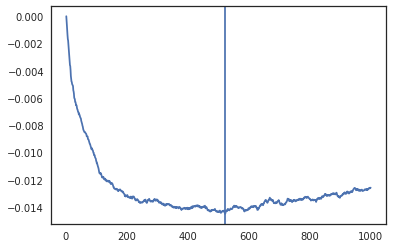

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X = data.drop(['class','ip_address','signup_time','purchase_time','device_id','user_id','age','purchase_value'],axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2)



params = {'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.5,
          'learning_rate': 0.1, 'min_samples_leaf': 10, 'random_state': 3}
n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1

clf = GradientBoostingClassifier(**params)
clf.fit(X_train,y_train)

def heldout_score(clf, X_test, y_test):
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score

test_score = heldout_score(clf, X_valid, y_valid)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]
plt.plot(x, test_score, label='Test loss')
plt.axvline(x=test_best_iter)

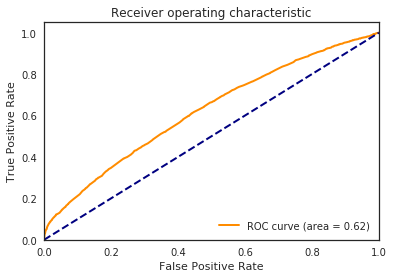

In [32]:
from sklearn.metrics import roc_curve, auc

y_pred = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",frameon=False)

plt.show()

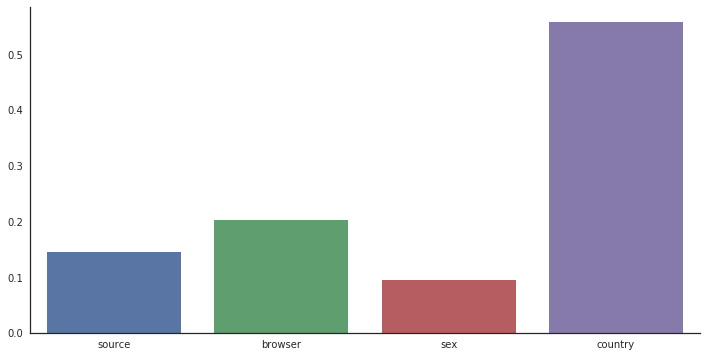

In [33]:
plt.figure(figsize=(12,6))
sns.set(style='white')
ax = sns.barplot(x=X.columns, y =clf.feature_importances_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)

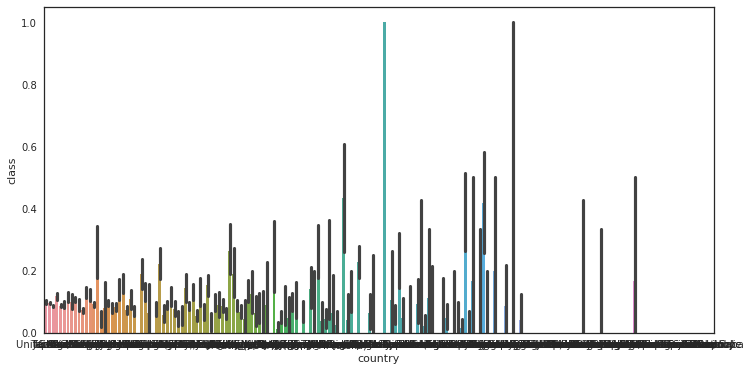

In [12]:
plt.figure(figsize=(12,6))
sns.set(style='white')
ax = sns.barplot(x='country', y='class',data=Fraud_Data)

In [13]:
Fraud_Data.groupby('country')['class'].mean().sort_values(ascending=False)[:10]

country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

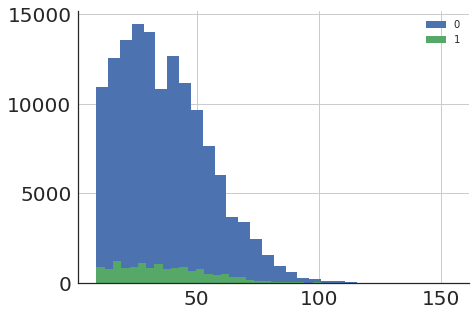

In [30]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
Fraud_Data.loc[Fraud_Data['class']==0,'purchase_value'].hist(bins=30,ax=ax,label='0')
Fraud_Data.loc[Fraud_Data['class']==1,'purchase_value'].hist(bins=30,ax=ax,label='1')
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

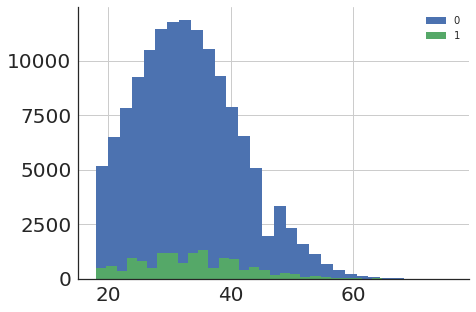

In [15]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
Fraud_Data.loc[Fraud_Data['class']==0,'age'].hist(bins=30,ax=ax,label='0')
Fraud_Data.loc[Fraud_Data['class']==1,'age'].hist(bins=30,ax=ax,label='1')
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

# Lightgbm

In [34]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)

lgb_eval = lgb.Dataset(X_valid,y_valid)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    #'num_leaves': 8,
    'learning_rate': 0.1,
    'verbose': 50
}
print('Start training...')
# train
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                evals_result=evals_result,
                early_stopping_rounds=1)


Start training...
[1]	valid_0's binary_logloss: 0.630539
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's binary_logloss: 0.579448
[3]	valid_0's binary_logloss: 0.537328
[4]	valid_0's binary_logloss: 0.502285
[5]	valid_0's binary_logloss: 0.472906
[6]	valid_0's binary_logloss: 0.448206
[7]	valid_0's binary_logloss: 0.427328
[8]	valid_0's binary_logloss: 0.409632
[9]	valid_0's binary_logloss: 0.394656
[10]	valid_0's binary_logloss: 0.381918
[11]	valid_0's binary_logloss: 0.371145
[12]	valid_0's binary_logloss: 0.362014
[13]	valid_0's binary_logloss: 0.354229
[14]	valid_0's binary_logloss: 0.347681
[15]	valid_0's binary_logloss: 0.342135
[16]	valid_0's binary_logloss: 0.337365
[17]	valid_0's binary_logloss: 0.333416
[18]	valid_0's binary_logloss: 0.330024
[19]	valid_0's binary_logloss: 0.327208
[20]	valid_0's binary_logloss: 0.324862
[21]	valid_0's binary_logloss: 0.322847
[22]	valid_0's binary_logloss: 0.321154
[23]	valid_0's binary_logloss: 0.319709
[24]	valid

[ 0.10622567  0.08350077  0.08350077  0.09478942  0.05725136  0.09392615
  0.0975752   0.11286533  0.09638609  0.0967681 ]


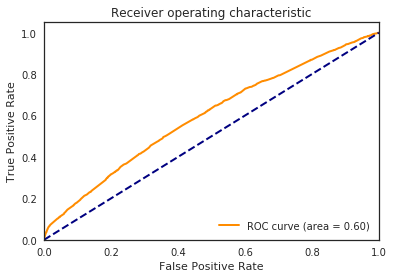

In [35]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print(y_pred[:10])
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",frameon=False)

plt.show()

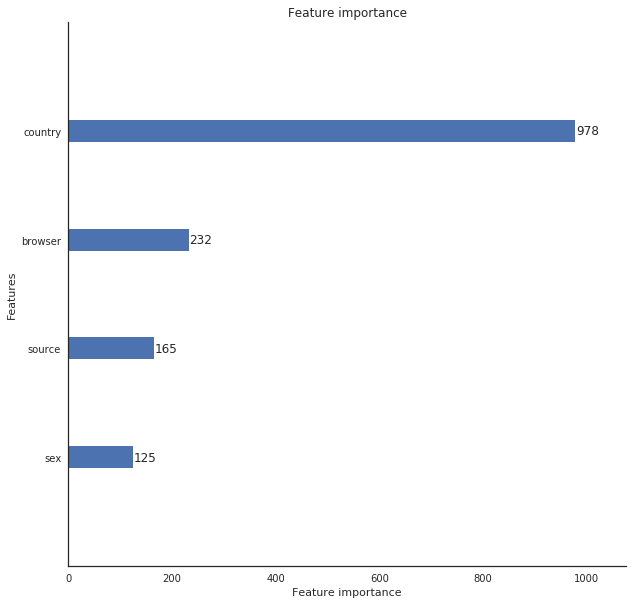

In [36]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='split')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()